<a href="https://colab.research.google.com/github/megretson/ColabFold/blob/main/RoseTTAFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RoseTTAFold
**Limitations**
- This notebook disables a few aspects (templates, pytosetta) of the full rosettafold pipeline.
- For best resuls use the [full pipeline](https://github.com/RosettaCommons/RoseTTAFold) or [Robetta webserver](https://robetta.bakerlab.org/)!
- For a typical Google-Colab session, with a `16G-GPU`, the max total length is **700 residues**. Sometimes a `12G-GPU` is assigned, in which case the max length is lower.
- For version of RoseTTAFold that runs with pyRosetta [see here](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/beta/RoseTTAFold.ipynb).

For other related notebooks see [ColabFold](https://github.com/sokrypton/ColabFold)

In [9]:
#@title ##Install and import libraries
#@markdown This step can take up to ~2 mins

import os
import sys
from IPython.utils import io
from google.colab import files
!pip install biopython
from google.colab import drive
from Bio import SeqIO

import torch
torch_v = torch.__version__

drive.mount('/content/gdrive')

if not os.path.isdir("RoseTTAFold"):
  with io.capture_output() as captured:
    # extra functionality
    %shell wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold.py

    # download model
    %shell git clone https://github.com/RosettaCommons/RoseTTAFold.git
    %shell wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/RoseTTAFold__network__Refine_module.patch
    %shell patch -u RoseTTAFold/network/Refine_module.py -i RoseTTAFold__network__Refine_module.patch

    # download model params
    %shell wget -qnc https://files.ipd.uw.edu/pub/RoseTTAFold/weights.tar.gz
    %shell tar -xf weights.tar.gz
    %shell rm weights.tar.gz

    # download scwrl4 (for adding sidechains)
    # http://dunbrack.fccc.edu/SCWRL3.php
    # Thanks Roland Dunbrack!
    %shell wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/scwrl4.zip
    %shell unzip -qqo scwrl4.zip

    # install libraries
    %shell pip install -q dgl-cu113 -f https://data.dgl.ai/wheels/repo.html
    %shell pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-{torch_v}.html
    %shell pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-{torch_v}.html
    %shell pip install -q torch-geometric
    %shell pip install -q py3Dmol
    %shell pip install biopython

with io.capture_output() as captured:
  sys.path.append('/content/RoseTTAFold/network')
  import predict_e2e
  from parsers import parse_a3m
  
import colabfold as cf
import py3Dmol
import subprocess
import numpy as np
import matplotlib.pyplot as plt

def get_bfactor(pdb_filename):
  bfac = []
  for line in open(pdb_filename,"r"):
    if line[:4] == "ATOM":
      bfac.append(float(line[60:66]))
  return np.array(bfac)

def set_bfactor(pdb_filename, bfac):
  I = open(pdb_filename,"r").readlines()
  O = open(pdb_filename,"w")
  for line in I:
    if line[0:6] == "ATOM  ":
      seq_id = int(line[22:26].strip()) - 1
      O.write(f"{line[:60]}{bfac[seq_id]:6.2f}{line[66:]}")
  O.close()    

def do_scwrl(inputs, outputs, exe="./scwrl4/Scwrl4"):
  subprocess.run([exe,"-i",inputs,"-o",outputs,"-h"],
                  stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
  bfact = get_bfactor(inputs)
  set_bfactor(outputs, bfact)
  return bfact

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
#@title Search against genetic databases
#@markdown ---
msa_method = "mmseqs2" #@param ["mmseqs2","single_sequence","custom_a3m"]
#@markdown - `mmseqs2` - FAST method from [ColabFold](https://github.com/sokrypton/ColabFold)
#@markdown - `single_sequence` - use single sequence input (not recommended, unless a *denovo* design and you dont expect to find any homologous sequences)
#@markdown - `custom_a3m` Upload custom MSA (a3m format)


def search_against_databases(jobname, sequence, msa_method):
  # tmp directory
  prefix = cf.get_hash(sequence)
  os.makedirs('tmp', exist_ok=True)
  prefix = os.path.join('tmp',prefix)

  os.makedirs(jobname, exist_ok=True)


  if msa_method == "mmseqs2":
    a3m_lines = cf.run_mmseqs2(sequence, prefix, filter=True)
    with open(f"{jobname}/msa.a3m","w") as a3m:
      a3m.write(a3m_lines)

  elif msa_method == "single_sequence":
    with open(f"{jobname}/msa.a3m","w") as a3m:
      a3m.write(f">{jobname}\n{sequence}\n")

  elif msa_method == "custom_a3m":
    print("upload custom a3m")
    msa_dict = files.upload()
    lines = msa_dict[list(msa_dict.keys())[0]].decode().splitlines()
    a3m_lines = []
    for line in lines:
      line = line.replace("\x00","")
      if len(line) > 0 and not line.startswith('#'):
        a3m_lines.append(line)

    with open(f"{jobname}/msa.a3m","w") as a3m:
      a3m.write("\n".join(a3m_lines))

  msa_all = parse_a3m(f"{jobname}/msa.a3m")
  msa_arr = np.unique(msa_all,axis=0)
  total_msa_size = len(msa_arr)
  if msa_method == "mmseqs2":
    print(f'\n{total_msa_size} Sequences Found in Total (after filtering)\n')
  else:
    print(f'\n{total_msa_size} Sequences Found in Total\n')

  if total_msa_size > 1:
    plt.figure(figsize=(8,5),dpi=100)
    plt.title("Sequence coverage")
    seqid = (msa_all[0] == msa_arr).mean(-1)
    seqid_sort = seqid.argsort()
    non_gaps = (msa_arr != 20).astype(float)
    non_gaps[non_gaps == 0] = np.nan
    plt.imshow(non_gaps[seqid_sort]*seqid[seqid_sort,None],
              interpolation='nearest', aspect='auto',
              cmap="rainbow_r", vmin=0, vmax=1, origin='lower',
              extent=(0, msa_arr.shape[1], 0, msa_arr.shape[0]))
    plt.plot((msa_arr != 20).sum(0), color='black')
    plt.xlim(0,msa_arr.shape[1])
    plt.ylim(0,msa_arr.shape[0])
    plt.colorbar(label="Sequence identity to query",)
    plt.xlabel("Positions")
    plt.ylabel("Sequences")
    plt.savefig(f"{jobname}/msa_coverage.png", bbox_inches = 'tight')
    plt.show()

In [11]:
#@title ## Run RoseTTAFold for mainchain and Scrwl4 for sidechain prediction

def run_rosettafold(jobname):
  # load model
  if "rosettafold" not in dir():
    rosettafold = predict_e2e.Predictor(model_dir="weights")

  # make prediction using model
  rosettafold.predict(f"{jobname}/msa.a3m",f"{jobname}/pred")

  # pack sidechains using Scwrl4
  plddt = do_scwrl(f"{jobname}/pred.pdb",f"{jobname}/pred.scwrl.pdb")

  print(f"Predicted LDDT: {plddt.mean()}")

  plt.figure(figsize=(8,5),dpi=100)
  plt.plot(plddt)
  plt.xlabel("positions")
  plt.ylabel("plddt")
  plt.ylim(0,1)
  plt.savefig(f"{jobname}/plddt.png", bbox_inches = 'tight')
  plt.show()


In [13]:
def display_structure(jobname):
  #@title Display 3D structure {run: "auto"}
  color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
  show_sidechains = False #@param {type:"boolean"}
  show_mainchains = False #@param {type:"boolean"}
  cf.show_pdb(f"{jobname}/pred.scwrl.pdb", show_sidechains, show_mainchains, color, chains=1, vmin=0.5, vmax=0.9).show()

  if color == "lDDT": cf.plot_plddt_legend().show()  

In [91]:
#@title Download prediction

#@markdown Once this cell has been executed, a zip-archive with 
#@markdown the obtained prediction will be automatically downloaded 
#@markdown to your computer.

def save_to_drive(jobname, sequence, msa_method):
  # add settings file
  %cd /content/
  !zip -r /content/{jobname}.zip /content/{jobname}/
  %cd /content/gdrive/My\ Drive/
  !mkdir -p ./collab/{jobname}/
  ! mv ../../{jobname}.zip ./collab/{jobname}/
  settings_path = "./collab/{}/settings.txt".format(jobname)

  with open(settings_path, "w") as text_file:
    text_file.write(f"method=RoseTTAFold\n")
    text_file.write(f"sequence={sequence}\n")
    text_file.write(f"msa_method={msa_method}\n")
    text_file.write(f"use_templates=False\n")
  
  !rm -r /content/{jobname}/


/content
/content

191 Sequences Found in Total (after filtering)



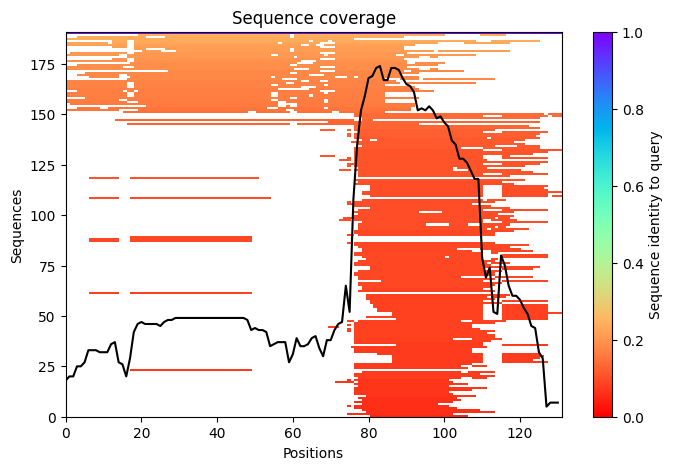

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:352: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), "Cannot convert view " \


SE(3) iteration 0 [0.4575]
SE(3) iteration 1 [0.522]
SE(3) iteration 2 [0.5386]
SE(3) iteration 3 [0.568]
SE(3) iteration 4 [0.5835]
SE(3) iteration 5 [0.575]
SE(3) iteration 6 [0.602]
SE(3) iteration 7 [0.6294]
SE(3) iteration 8 [0.6304]
SE(3) iteration 9 [0.629]
SE(3) iteration 10 [0.629]
SE(3) iteration 11 [0.628]
SE(3) iteration 12 [0.628]
SE(3) iteration 13 [0.628]
SE(3) iteration 14 [0.6274]
SE(3) iteration 15 [0.6274]
SE(3) iteration 16 [0.6274]
SE(3) iteration 17 [0.6274]
SE(3) iteration 18 [0.6274]
SE(3) iteration 19 [0.6274]
SE(3) iteration 0 [0.4524]
SE(3) iteration 1 [0.5015]
SE(3) iteration 2 [0.559]
SE(3) iteration 3 [0.581]
SE(3) iteration 4 [0.604]
SE(3) iteration 5 [0.621]
SE(3) iteration 6 [0.6265]
SE(3) iteration 7 [0.6274]
SE(3) iteration 8 [0.6274]
SE(3) iteration 9 [0.6274]
SE(3) iteration 10 [0.6274]
SE(3) iteration 11 [0.6274]
SE(3) iteration 12 [0.6274]
SE(3) iteration 13 [0.6274]
SE(3) iteration 14 [0.6274]
SE(3) iteration 15 [0.6274]
SE(3) iteration 16 [0.627

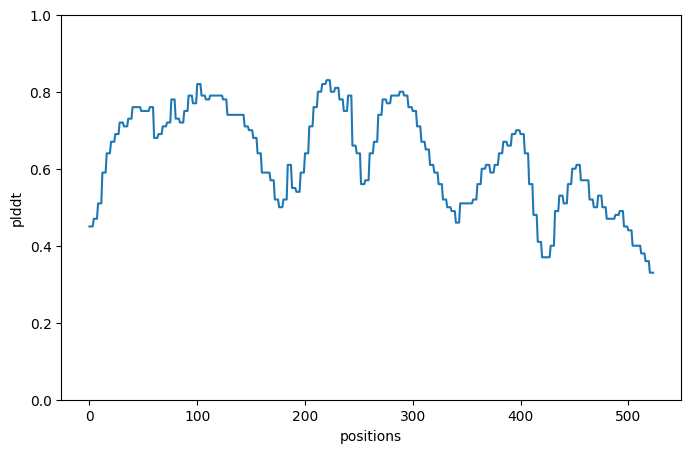

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

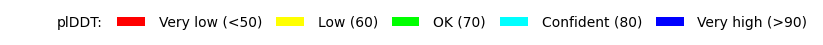

/content
  adding: content/test_4FPQ/ (stored 0%)
  adding: content/test_4FPQ/pred.npz (deflated 0%)
  adding: content/test_4FPQ/plddt.png (deflated 9%)
  adding: content/test_4FPQ/pred_init.pdb (deflated 74%)
  adding: content/test_4FPQ/msa.a3m (deflated 70%)
  adding: content/test_4FPQ/msa_coverage.png (deflated 7%)
  adding: content/test_4FPQ/pred.scwrl.pdb (deflated 78%)
  adding: content/test_4FPQ/pred.pdb (deflated 75%)
/content/gdrive/My Drive
/content


  0%|          | 0/150 [elapsed: 00:00 remaining: ?]


10251 Sequences Found in Total (after filtering)



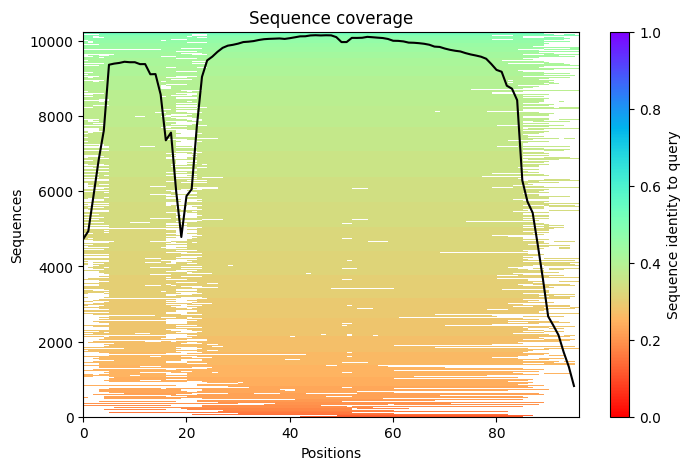

SE(3) iteration 0 [0.7163]
SE(3) iteration 1 [0.789]
SE(3) iteration 2 [0.8296]
SE(3) iteration 3 [0.8467]
SE(3) iteration 4 [0.848]
SE(3) iteration 5 [0.85]
SE(3) iteration 6 [0.8506]
SE(3) iteration 7 [0.85]
SE(3) iteration 8 [0.8506]
SE(3) iteration 9 [0.85]
SE(3) iteration 10 [0.85]
SE(3) iteration 11 [0.8506]
SE(3) iteration 12 [0.8496]
SE(3) iteration 13 [0.8496]
SE(3) iteration 14 [0.8496]
SE(3) iteration 15 [0.8496]
SE(3) iteration 16 [0.8496]
SE(3) iteration 17 [0.8496]
SE(3) iteration 18 [0.8496]
SE(3) iteration 19 [0.8496]
SE(3) iteration 20 [0.8496]
SE(3) iteration 21 [0.8496]
SE(3) iteration 22 [0.8496]
SE(3) iteration 0 [0.7227]
SE(3) iteration 1 [0.755]
SE(3) iteration 2 [0.7993]
SE(3) iteration 3 [0.84]
SE(3) iteration 4 [0.8467]
SE(3) iteration 5 [0.8486]
SE(3) iteration 6 [0.849]
SE(3) iteration 7 [0.8496]
SE(3) iteration 8 [0.849]
SE(3) iteration 9 [0.8496]
SE(3) iteration 10 [0.8496]
SE(3) iteration 11 [0.8496]
SE(3) iteration 12 [0.8496]
SE(3) iteration 13 [0.8496]

In [ ]:
# reference for later, in case it's useful: https://stackoverflow.com/questions/47320052/load-local-data-files-to-colaboratory
%cd /content/
msa_method = "mmseqs2"
sequences = SeqIO.parse("all_seqs.fasta", "fasta")
max = 500
count = 0

for seq_record in sequences:
  if count < max:
    %cd /content/
    sequence = str(seq_record.seq)
    sequence = sequence.translate(str.maketrans('', '', ' \n\t')).upper()
    sequence_id =  seq_record.id.split("_")[0]
    jobname = "test_" + sequence_id
    search_against_databases(jobname, sequence, msa_method)
    run_rosettafold(jobname)
    display_structure(jobname)
    save_to_drive(jobname, sequence, msa_method)
    count += 1 
    

/content
updating: content/test_4FPQ/ (stored 0%)
updating: content/test_4FPQ/pred.npz (deflated 0%)
updating: content/test_4FPQ/plddt.png (deflated 9%)
updating: content/test_4FPQ/pred_init.pdb (deflated 74%)
updating: content/test_4FPQ/msa.a3m (deflated 70%)
updating: content/test_4FPQ/msa_coverage.png (deflated 7%)
updating: content/test_4FPQ/pred.scwrl.pdb (deflated 78%)
updating: content/test_4FPQ/pred.pdb (deflated 74%)
/content/gdrive/My Drive
